In [3]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM, SimpleRNN, Bidirectional
from tensorflow.keras.layers import Dense
from keras.callbacks import EarlyStopping
nltk.download('stopwords')
import unittest
import os
from io import StringIO

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lxy99\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load Dataset

In [6]:
def load_and_prepare_data(filepath: str = 'train.csv') -> tuple[pd.DataFrame, pd.Series, pd.DataFrame]:
    """
    Load and preprocess the dataset.

    Parameters:
        filepath (str): Path to the CSV file. Defaults to 'train.csv'.

    Returns:
        tuple: Tuple containing the following:
            - X (pd.DataFrame): Features dataframe.
            - Y (pd.Series): Labels.
            - messages (pd.DataFrame): Copy of X with index reset.
    """
    df = pd.read_csv(filepath)  # Only load train data, test data does not have label
    print("Data shape:", df.shape)  # Size of data
    print(df.head())  # Show few lines

    print("Missing values before fill:")
    print(df.isnull().sum())  # checking the missing values
    df = df.fillna('')  # replacing null values with empty string
    print("Missing values after fill:")
    print(df.isnull().sum())

    df['content'] = df['title'] + " " + df['author']  # Merge title and author
    print(df.head())

    X = df.drop(columns='label', axis=1)  # separating the data
    Y = df['label']  # labels
    print(X.head())
    print(Y.head())

    messages = X.copy()
    print(messages['title'][1])
    messages.reset_index(inplace=True)

    return X, Y, messages

# Example usage
X, Y, messages = load_and_prepare_data()

Data shape: (20800, 5)
   id                                              title              author  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2   2                  Why the Truth Might Get You Fired  Consortiumnews.com   
3   3  15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4   4  Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                text  label  
0  House Dem Aide: We Didn’t Even See Comey’s Let...      1  
1  Ever get the feeling your life circles the rou...      0  
2  Why the Truth Might Get You Fired October 29, ...      1  
3  Videos 15 Civilians Killed In Single US Airstr...      1  
4  Print \nAn Iranian woman has been sentenced to...      1  
Missing values before fill:
id           0
title      558
author    1957
text        39
label        0
dtype: int64
Missing 

In [8]:
class TestLoadAndPrepareData(unittest.TestCase):
    def setUp(self):
        self.fake_csv = StringIO(
            "id,title,author,text,label\n"
            "1,Fake news title,John Doe,Some text,0\n"
            "2,Another news title,,Another text,1\n"
        )
        self.temp_path = "temp_fake_train.csv"
        with open(self.temp_path, "w") as f:
            f.write(self.fake_csv.getvalue())

    def test_load_and_prepare_data(self):
        X, Y, messages = load_and_prepare_data(self.temp_path)
        self.assertEqual(len(X), 2)
        self.assertEqual(len(Y), 2)
        self.assertIn("content", X.columns)
        self.assertTrue(isinstance(messages, pd.DataFrame))

    def tearDown(self):
        if os.path.exists(self.temp_path):
            os.remove(self.temp_path)

# Run the test
unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(TestLoadAndPrepareData))

.
----------------------------------------------------------------------
Ran 1 test in 0.025s

OK


Data shape: (2, 5)
   id               title    author          text  label
0   1     Fake news title  John Doe     Some text      0
1   2  Another news title       NaN  Another text      1
Missing values before fill:
id        0
title     0
author    1
text      0
label     0
dtype: int64
Missing values after fill:
id        0
title     0
author    0
text      0
label     0
dtype: int64
   id               title    author          text  label  \
0   1     Fake news title  John Doe     Some text      0   
1   2  Another news title            Another text      1   

                    content  
0  Fake news title John Doe  
1       Another news title   
   id               title    author          text                   content
0   1     Fake news title  John Doe     Some text  Fake news title John Doe
1   2  Another news title            Another text       Another news title 
0    0
1    1
Name: label, dtype: int64
Another news title


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

# Stemming

In [10]:
def stem_corpus(messages: pd.DataFrame) -> list[str]:
    """
    Apply stemming and stopword removal to the 'title' field of the messages.

    Parameters:
        messages (pd.DataFrame): DataFrame containing the 'title' column.

    Returns:
        list[str]: List of processed and stemmed text entries.
    """
    ps = PorterStemmer()
    stop_words = set(stopwords.words('english'))
    corpus = []
    for i in range(len(messages)):
        stemmed = re.sub('[^a-zA-Z]', ' ', messages['title'][i])
        stemmed = stemmed.lower().strip()
        words = stemmed.split()
        stemmed_words = [ps.stem(word) for word in words if word not in stop_words]
        corpus.append(' '.join(stemmed_words))
    return corpus

In [12]:
corpus = stem_corpus(messages)

In [16]:
# Create a unit test for stem_corpus
class TestStemCorpus(unittest.TestCase):
    def test_stem_corpus_basic(self):
        data = pd.DataFrame({
            'title': ["Breaking news in tech world", "AI is taking over", "New iPhone released"]
        })
        result = stem_corpus(data)
        # Basic assertions
        self.assertEqual(len(result), 3)
        self.assertIsInstance(result[0], str)
        self.assertTrue(all(isinstance(item, str) for item in result))
        # Check stemming works (e.g., 'breaking' becomes 'break')
        self.assertIn('break', result[0])
        self.assertNotIn('breaking', result[0])

# Run the test
unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(TestStemCorpus))

.
----------------------------------------------------------------------
Ran 1 test in 0.003s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

In [28]:
def tokenize_and_pad(corpus: list[str], vocab_size: int = 10000, max_len: int = 20) -> np.ndarray:
    """
    Convert text corpus into padded sequences of one-hot encoded integers.

    Parameters:
        corpus (list[str]): List of stemmed text entries.
        vocab_size (int): Vocabulary size for one-hot encoding.
        max_len (int): Maximum length for padded sequences.

    Returns:
        np.ndarray: Padded sequence representation of the corpus.
    """
    if not isinstance(corpus, list):
        raise ValueError("Input 'corpus' must be a list of sentences (strings).")
    onehot_repr = [one_hot(words, vocab_size) for words in corpus]
    embedded_docs = pad_sequences(onehot_repr, padding='pre', maxlen=max_len)
    print(embedded_docs)
    return embedded_docs

In [30]:
embedded_docs = tokenize_and_pad(corpus)

[[   0    0    0 ... 4462 2348 7349]
 [   0    0    0 ... 8218 2803 3633]
 [   0    0    0 ... 2577 1740 8947]
 ...
 [   0    0    0 ...  602 2508 2599]
 [   0    0    0 ... 6702 9962 7085]
 [   0    0    0 ... 2293 4535 6332]]


In [38]:
def prepare_final_data(embedded_docs: np.ndarray, labels: pd.Series) -> tuple[np.ndarray, np.ndarray]:
    """
    Prepare final NumPy arrays for model training.

    Parameters:
        embedded_docs (np.ndarray): Padded sequences.
        labels (pd.Series): Target labels.

    Returns:
        tuple: Tuple containing final feature and label arrays.
    """
    X_final = np.array(embedded_docs)
    Y_final = np.array(labels)
    print(X_final)
    print(Y_final)
    return X_final, Y_final

In [40]:
X_final, Y_final = prepare_final_data(embedded_docs, Y)

[[   0    0    0 ... 4462 2348 7349]
 [   0    0    0 ... 8218 2803 3633]
 [   0    0    0 ... 2577 1740 8947]
 ...
 [   0    0    0 ...  602 2508 2599]
 [   0    0    0 ... 6702 9962 7085]
 [   0    0    0 ... 2293 4535 6332]]
[1 0 1 ... 0 1 1]


In [44]:
class TestPrepareFinalData(unittest.TestCase):
    def test_prepare_final_data_shapes(self):
        # Simulated padded sequences and labels
        embedded_docs = np.array([
            [1, 2], [3, 4], [5, 6]
        ])
        labels = pd.Series([1, 0, 1])

        X_final, Y_final = prepare_final_data(embedded_docs, labels)

        # Assertions
        self.assertEqual(X_final.shape, (3, 2))
        self.assertEqual(Y_final.shape, (3,))
        self.assertTrue((Y_final == labels.values).all())

# Run the test
unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(TestPrepareFinalData))

.
----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


[[1 2]
 [3 4]
 [5 6]]
[1 0 1]


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

# Split data

In [46]:
def split_data(X: np.ndarray, Y: np.ndarray, test_size: float = 0.2, random_state: int = 50) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Split the data into training and test sets.

    Parameters:
        X (np.ndarray): Feature data.
        Y (np.ndarray): Label data.
        test_size (float): Proportion of test data.
        random_state (int): Random seed for reproducibility.

    Returns:
        tuple: X_train, X_test, Y_train, Y_test
    """
    return train_test_split(X, Y, test_size=test_size, random_state=random_state)

In [48]:
X_train, X_test, Y_train, Y_test = split_data(X_final, Y_final)

In [50]:
print(f"The size of X_train and Y_train is: {X_train.shape[0]}, {Y_train.shape[0]}")
print(f"The size of X_test and Y_test is: {X_test.shape[0]}, {Y_test.shape[0]}")

The size of X_train and Y_train is: 16640, 16640
The size of X_test and Y_test is: 4160, 4160


In [52]:
class TestSplitData(unittest.TestCase):
    def test_split_data_shapes(self):
        X = np.array([[1, 2], [3, 4], [5, 6], [7, 8]])
        Y = np.array([0, 1, 0, 1])

        X_train, X_test, Y_train, Y_test = split_data(X, Y, test_size=0.5, random_state=42)

        self.assertEqual(X_train.shape[0], 2)
        self.assertEqual(X_test.shape[0], 2)
        self.assertEqual(Y_train.shape[0], 2)
        self.assertEqual(Y_test.shape[0], 2)
        self.assertEqual(X_train.shape[1], X.shape[1])
        self.assertTrue(set(Y_train).issubset({0, 1}))

# Run test
unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(TestSplitData))

.
----------------------------------------------------------------------
Ran 1 test in 0.003s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

# RNN

In [54]:
def build_and_train_rnn(X_train, Y_train, X_test, Y_test,
                        voc, max_len,
                        embedding_vector_features=40,
                        epochs=20, batch_size=32):
    
    rnn = Sequential()
    rnn.add(Embedding(input_dim=voc, output_dim=embedding_vector_features))

    rnn.add(SimpleRNN(100, return_sequences=False))
    rnn.add(Dropout(0.5))  # Helps reduce overfitting

    # If you want L2 regularization, replace the line below with:
    # rnn.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))
    rnn.add(Dense(1, activation='sigmoid'))

    rnn.build(input_shape=(None, max_len))
    rnn.summary()
    
    rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = rnn.fit(X_train, Y_train,
                      epochs=epochs,
                      batch_size=batch_size,
                      validation_data=(X_test, Y_test),
                      callbacks=[early_stop])
    return rnn, history

In [56]:
rnn_model, history = build_and_train_rnn(X_train, Y_train, X_test, Y_test, 10000,20)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 20, 40)         │       400,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 100)            │        14,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 414,201 (1.58 MB)

 Trainable params: 414,201 (1.58 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
520/520 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.8569 - loss: 0.3359 - val_accuracy: 0.9279 - val_loss: 0.1684
Epoch 2/20
520/520 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9714 - loss: 0.0847 - val_accuracy: 0.9284 - val_loss: 0.1951
Epoch 3/20
520/520 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9945 - loss: 0.0212 - val_accuracy: 0.9144 - val_loss: 0.2683
Epoch 4/20
520/520 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9983 - loss: 0.0057 - val_accuracy: 0.9252 - val_loss: 0.3584


In [58]:
class TestBuildAndTrainRNN(unittest.TestCase):
    def test_rnn_model_training(self):
        X_train = np.random.randint(0, 5000, (10, 20))
        Y_train = np.random.randint(0, 2, 10)
        X_test = np.random.randint(0, 5000, (5, 20))
        Y_test = np.random.randint(0, 2, 5)

        voc = 5000
        max_len = 20

        model, history = build_and_train_rnn(X_train, Y_train, X_test, Y_test, voc, max_len, epochs=1, batch_size=2)

        self.assertIsNotNone(model)
        self.assertTrue(hasattr(model, "predict"))
        self.assertTrue("accuracy" in history.history)

# Run test
unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(TestBuildAndTrainRNN))

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 20, 40)         │       200,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 100)            │        14,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 214,201 (836.72 KB)

 Trainable params: 214,201 (836.72 KB)

 Non-trainable params: 0 (0.00 B)

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.6236 - loss: 0.6661 - val_accuracy: 0.6000 - val_loss: 0.6501


.
----------------------------------------------------------------------
Ran 1 test in 2.147s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

In [62]:
def analyze_performance(history, model, X_test, Y_test):
    """
    Analyze and visualize the model's performance using accuracy, loss, classification metrics,
    and display some incorrect prediction examples with text and author details.
    """
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Training Accuracy", c="red")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy", c="blue")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Training Loss", c="red")
    plt.plot(history.history["val_loss"], label="Validation Loss", c="blue")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

    y_pred = model.predict(X_test)
    y_pred_classes = (y_pred > 0.5).astype(int)
    acc = accuracy_score(Y_test, y_pred_classes)
    cm = confusion_matrix(Y_test, y_pred_classes)

    print("Accuracy Score:", acc)
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", classification_report(Y_test, y_pred_classes))

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.title("Confusion Matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

    wrong_indices = np.where(Y_test != y_pred_classes.reshape(-1))[0]
    print("\nExamples of wrong predictions with details:")
    for i, idx in enumerate(wrong_indices[:5]):
        print(f"\nExample {i + 1}:")
        print(f"Title: {messages.loc[idx, 'title']}")
        print(f"Author: {messages.loc[idx, 'author']}")
        print(f"Actual Label: {Y_test[idx]}, Predicted Label: {y_pred_classes[idx][0]}")

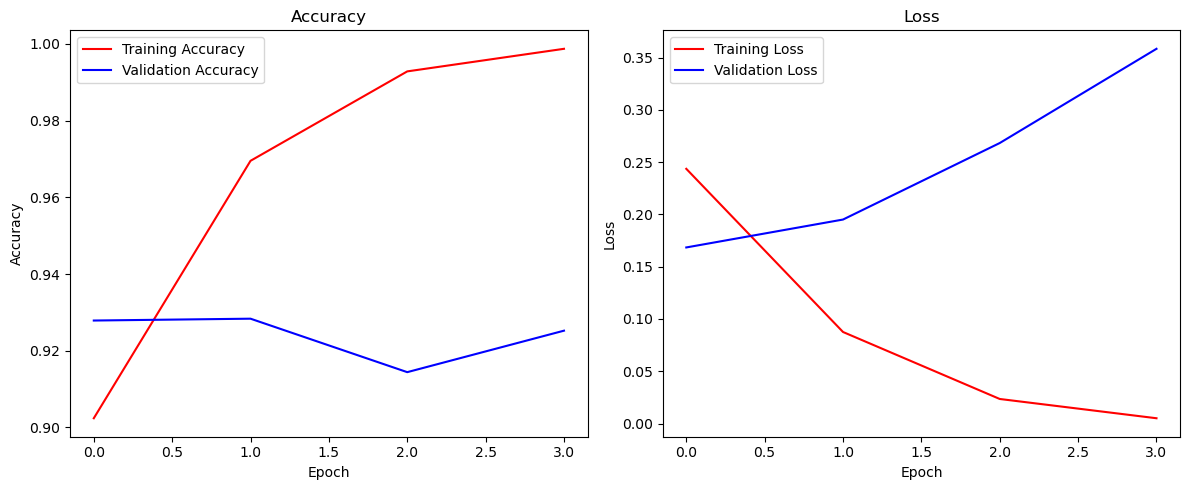

130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Accuracy Score: 0.9278846153846154
Confusion Matrix:
 [[1843  242]
 [  58 2017]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.88      0.92      2085
           1       0.89      0.97      0.93      2075

    accuracy                           0.93      4160
   macro avg       0.93      0.93      0.93      4160
weighted avg       0.93      0.93      0.93      4160



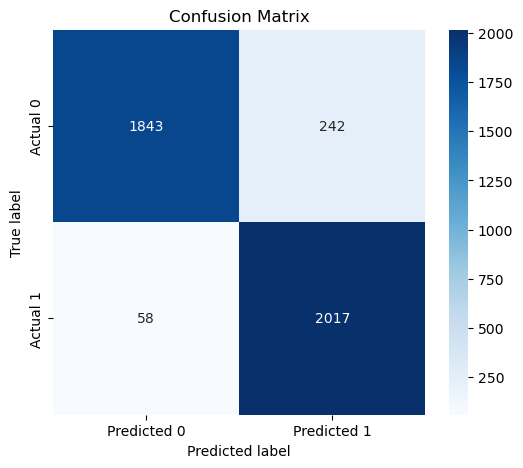


Examples of wrong predictions with details:

Example 1:
Title: Iranian woman jailed for fictional unpublished story about woman stoned to death for adultery
Author: Howard Portnoy
Actual Label: 0, Predicted Label: 1

Example 2:
Title: US Officials See No Link Between Trump and Russia
Author: Jason Ditz
Actual Label: 0, Predicted Label: 1

Example 3:
Title: Humiliated Hillary Tries To Hide What Camera Caught 15 Mins Before Rally
Author: Amanda Shea
Actual Label: 0, Predicted Label: 1

Example 4:
Title: I wonder what GLP will be like the day after the election?
Author: Anonymous Coward (UID 12781064)
Actual Label: 0, Predicted Label: 1

Example 5:
Title: Pence Will Speak at Anti-Abortion Rally - The New York Times
Author: Jeremy W. Peters
Actual Label: 0, Predicted Label: 1


In [64]:
analyze_performance(history, rnn_model, X_test, Y_test)

# LSTM

In [66]:
def build_and_train_lstm(X_train: np.ndarray, Y_train: np.ndarray,
                         X_test: np.ndarray, Y_test: np.ndarray,
                         voc: int, max_len: int,
                         embedding_vector_features: int = 40,
                         epochs: int = 20, batch_size: int = 32) -> tuple[Sequential, any]:
    
    lstm = Sequential()
    lstm.add(Embedding(input_dim=voc, output_dim=embedding_vector_features))
    lstm.add(Dropout(0.3))
    lstm.add(LSTM(100))
    lstm.add(Dropout(0.3))

    # Optional: L2 regularization
    # lstm.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))
    lstm.add(Dense(1, activation='sigmoid'))

    lstm.build(input_shape=(None, max_len))
    lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    lstm.summary()

    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = lstm.fit(X_train, Y_train,
                       epochs=epochs,
                       batch_size=batch_size,
                       validation_data=(X_test, Y_test),
                       callbacks=[early_stop])

    return lstm, history

In [68]:
lstm_model, lstm_history = build_and_train_lstm(X_train, Y_train, X_test, Y_test, 10000,20)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 20, 40)         │       400,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100)            │        56,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 456,501 (1.74 MB)

 Trainable params: 456,501 (1.74 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
520/520 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.8223 - loss: 0.3533 - val_accuracy: 0.9298 - val_loss: 0.1729
Epoch 2/20
520/520 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9561 - loss: 0.1167 - val_accuracy: 0.9308 - val_loss: 0.1765
Epoch 3/20
520/520 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9694 - loss: 0.0892 - val_accuracy: 0.9291 - val_loss: 0.1834
Epoch 4/20
520/520 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9814 - loss: 0.0559 - val_accuracy: 0.9267 - val_loss: 0.2173


In [70]:
class TestBuildAndTrainLSTM(unittest.TestCase):
    def test_lstm_training(self):
        X_train = np.random.randint(0, 5000, (10, 20))
        Y_train = np.random.randint(0, 2, 10)
        X_test = np.random.randint(0, 5000, (5, 20))
        Y_test = np.random.randint(0, 2, 5)

        voc = 5000
        max_len = 20

        model, history = build_and_train_lstm(X_train, Y_train, X_test, Y_test, voc, max_len, epochs=1, batch_size=2)

        self.assertIsNotNone(model)
        self.assertTrue(hasattr(model, "predict"))
        self.assertIn("accuracy", history.history)

# Run the test
unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(TestBuildAndTrainLSTM))

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 20, 40)         │       200,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 20, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        56,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 256,501 (1001.96 KB)

 Trainable params: 256,501 (1001.96 KB)

 Non-trainable params: 0 (0.00 B)

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.5375 - loss: 0.6949 - val_accuracy: 0.6000 - val_loss: 0.6927


.
----------------------------------------------------------------------
Ran 1 test in 2.220s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

In [72]:
def evaluate_lstm_model(model, history, X_test, Y_test, messages):
    y_pred = model.predict(X_test)
    y_pred_classes = (y_pred > 0.5).astype(int)

    acc = accuracy_score(Y_test, y_pred_classes)
    cm = confusion_matrix(Y_test, y_pred_classes)

    print("LSTM Model Evaluation")
    print("Accuracy Score:", acc)
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", classification_report(Y_test, y_pred_classes))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Training Accuracy", c="red")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy", c="blue")
    plt.title("LSTM Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Training Loss", c="red")
    plt.plot(history.history["val_loss"], label="Validation Loss", c="blue")
    plt.title("LSTM Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
    plt.title("LSTM Confusion Matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

    wrong_indices = np.where(Y_test != y_pred_classes.reshape(-1))[0]
    print("\nLSTM Wrong Predictions with Details:")
    for i, idx in enumerate(wrong_indices[:5]):
        print(f"\nExample {i+1}:")
        print(f"Title: {messages.loc[idx, 'title']}")
        print(f"Author: {messages.loc[idx, 'author']}")
        print(f"Actual: {Y_test[idx]}, Predicted: {y_pred_classes[idx][0]}")

130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
LSTM Model Evaluation
Accuracy Score: 0.9298076923076923
Confusion Matrix:
 [[1866  219]
 [  73 2002]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.89      0.93      2085
           1       0.90      0.96      0.93      2075

    accuracy                           0.93      4160
   macro avg       0.93      0.93      0.93      4160
weighted avg       0.93      0.93      0.93      4160



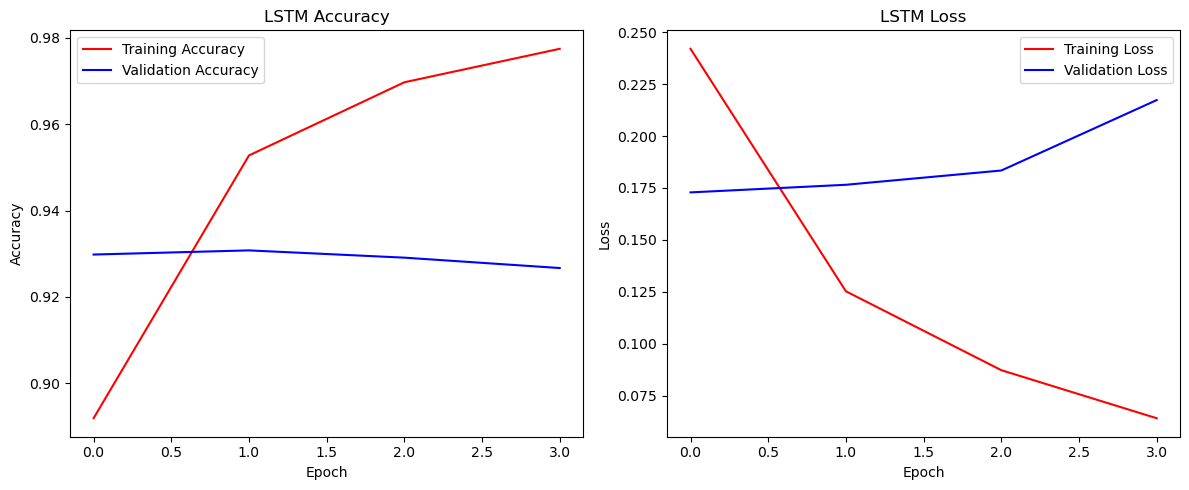

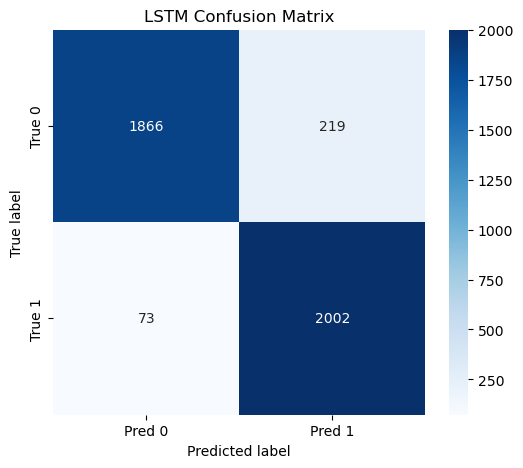


LSTM Wrong Predictions with Details:

Example 1:
Title: US Officials See No Link Between Trump and Russia
Author: Jason Ditz
Actual: 0, Predicted: 1

Example 2:
Title: Abortion Pill Orders Rise in 7 Latin American Nations on Zika Alert - The New York Times
Author: Donald G. McNeil Jr. and Pam Belluck
Actual: 0, Predicted: 1

Example 3:
Title: Humiliated Hillary Tries To Hide What Camera Caught 15 Mins Before Rally
Author: Amanda Shea
Actual: 0, Predicted: 1

Example 4:
Title: Pence Will Speak at Anti-Abortion Rally - The New York Times
Author: Jeremy W. Peters
Actual: 0, Predicted: 1

Example 5:
Title: Hillary Clinton Builds $150 Million War Chest, Doubling Donald Trump - The New York Times
Author: Nicholas Confessore and Rachel Shorey
Actual: 0, Predicted: 1


In [74]:
evaluate_lstm_model(lstm_model, lstm_history, X_test, Y_test, messages)

# Save Model

In [77]:
def save_model(model, path):
    """
    Save a trained Keras model in .h5 format.

    Args:
        model (Sequential): The trained Keras model.
        path (str): File path to save the model.
    """
    model.save(path)
    print(f"Model saved to {path}")

In [79]:
save_model(lstm_model,"lstm_model.keras")

Model saved to lstm_model.keras


In [81]:
save_model(rnn_model,"rnn_model.keras")

Model saved to rnn_model.keras
